# Spectral Embedding

Embedding is an import machine learning concept. Embeddings use some form of context to map discrete or categorical variables into real-number vector representations. See https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526 for a brief background on embeddings.

The increasing interest in Graph Neural Networks raises the interesting question of how to create an embedding within the context of connections and relationships. Ideally, graph node embedding space similiarity (e.g. cosine similarity) reflects graph node similarity within the context of graph connections.

One application of graph node embedding is to create representations that are suitable for clustering, i.e. graph nodes that are similar w.r.t. their connections will be grouped together in the embedding space.

Spectral Embedding is one mechanism for creating graph node embeddings based on connections. Spectral embeddings are computed as opposed to "learned" as is the case with other forms of embeddings. The process is simple to ipmlement, but involves some linear algebra. Fortunately, the complicated bits are easily handled with high performance library functions.

In [38]:
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline


## Spectral Embedding Outline

The following outline gives the steps for creating spectral embeddings for graph nodes. It represents an implementation modeled from an excellent presentation given by Tselil Schramm (Simons Institute) in 2017 (https://www.youtube.com/watch?v=-Afa1WI3iug) in the context of Graph Clustering Algorithms. Some details for each section of the algorithm are given in connection with the Python code implementation.

1. Create an adjacency matrix representation of the graph
2. Compute the Laplacian representation
3. Compute the Eigen-values/vectors of the Laplacian
4. Form the k-dimension embeddings map as the k eigenvectors corresponding to the smallest k eigenvalues, skipping the smallest eigenvalue, i.e. beginning with the next-to-smallest eigenvalue.

The embedding map is arranged with eigenvectors as columns, with the result for a N-node graph with k-dimension embeddings is a Nxk matrix where the jth graph node embedding is the jth row of the matrix, i.e. the jth element of each of the k eigenvectors.


## Step 1 - Create the Graph Adacency Matrix

A graph adjacency matrix, A, for a N-node graph is a NxN matrix where the rows and columns represent the graph nodes and connections between nodes are marked with an entry of 1. For instance, if node i is connected to node j, then a 1 will appear in A[i,j].

A straightforward way to store a graph representation is with an edge list. In this file format, each line consists of two, space-separated labels representing an edge between two nodes in the graph, the first label being the edge source, the second the destination. The following function will read a simplified edge-list file where node labels are a contiguous set of integers, and return the corresponding adjacency matrix.

As an example, a simple graph and its adjacency matrix are show below:

In [8]:
def read_edge_list(filename):
    #
    #   read the graph edges as node label tuples
    #
    edges = []
    with open(filename, encoding='utf-8') as f:
        for line in f.readlines():
            n1,n2 = line[:-1].split(' ')
            edges.append((int(n1),int(n2)))    
    #
    #   create a set of node labels
    #
    nodes = set()
    for edge in edges:
        nodes.add(edge[0])
        nodes.add(edge[1])
    nodes = list(nodes)
    N = len(nodes)
    #
    #   we assume that graph node labels are a set of contiguous integers
    #
    assert max(nodes) == N - 1
    #
    #   create the adjacency matrix from the list of edge tuples
    #
    A = np.zeros((N,N))
    A[[edge[0] for edge in edges], [edge[1] for edge in edges]] = 1

    return A



As an example, here is a simple graph. Its edge-list is stored in graph-edge-list-1.txt. Run the following cell and compare the output with the expected adjacency matrix.

<img src="figure-1-simple-graph.png">

In [9]:
A = read_edge_list('graph-edge-list-1.txt')
print(A)

[[0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 1. 1. 0. 1. 0.]]


Expected adjacency matrix.

<img src="figure-2-simple-graph-adjacency-matrix.png">

A graph with undirected edges will have a symmetric adjacency matrix and A[i,j] = A[j,i] for all i,j. In addtion, if no graph node has a direct connection to itself (self-loop), the adjacency matrix diagonal will contain all zeros, A[i,i] = 0 for all i. An undirected graph without self-loops is termed a "simple graph".


In [10]:
assert np.all(A == A.T) and np.all(np.diagonal(A) == 0)

## Step 2 - Compute the Graph Laplacian from the Adjacency Matrix
The graph Laplacian matrix is another, equivalent representation of the graph node connections with a little added information. In the Laplacian representation, node connections are labeled with a -1 instead of a 1. In addition to the node-to-node connection information, the diagonal elements represent the node degrees, i.e. the number of connections each node has. For instance, in the graph shown above, the Laplacian graph matrix, L, will have 2 in location L[0,0] meaning that node A has two connections to other nodes.

The Laplacian is computed from the adjacency matrix in two steps. First, the node degress are computed. Then tha result is combined with the adjacency matrix. To compute the node degrees, the marginal sum of the adjacency matrix is taken. It doesn't matter which axis is used for the sum since the matrix is symmteric. In the second step, the marginal sums are expanded into a diagonal matrix, zeros everywhere except along the diagonal, and the adjacency matrix is subtracted from it.

Compute the Laplacian from the adjacency matrix and compare with the expected result.

In [11]:
D = np.diag(np.sum(A, axis=0))
L = D - A
print(L)

[[ 2. -1.  0.  0.  0. -1.  0.  0.]
 [-1.  4. -1. -1. -1.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  3.  0.  0.  0. -1.]
 [ 0. -1.  0.  0.  3.  0. -1. -1.]
 [-1.  0.  0.  0.  0.  2. -1.  0.]
 [ 0.  0.  0.  0. -1. -1.  3. -1.]
 [ 0.  0.  0. -1. -1.  0. -1.  3.]]


Expected Laplacian matrix:

<img src="figure-3.png">

## Step 3 - Compute the Eigen Values and Vectors of the Graph Laplacian

The Eigen Values and Vectors (together called an Eigen System) of a NxN matix are the solutions to the linear algebra relation
Mv = lambda*v
where M is the NxN matrix, v is the set of Eigenvectors (also a NxN matrix) and lamda is the N-dimensional set of Eigenvalues. Eigenvectors can be thought of as the orthogonal axes of a coordinate syste, i.e. the dot product of any Eignenvector with another Eigenvector in the system is 0 except with itself in which case the result is 1. The Eigenvalues provide a scale factor for their corresponding Eigenvectors.

Eigen systems play an important role in many practical applications such as Principal Component Analysis where the Eigenvectors corresponding to the larger Eigenvalues are taken to form a coordinate system of lower dimensionality from the original data.

In this application, however, the spectral embedding is computed from the Eigenvectors corresonding to the smaller Eigen Vectors. No formal reasoning for this is given here, but some intuition can be gained by recognizing that the larger Eigenvalues indicate Eigenvectors with less entropy (a more discriminating direction), whereas embeddings are interested in grouping, not separating entities. As will be shown later, the Eigenvector corresponding to the second smallest Eigenvalue can be used to partition a graph into two components using the fewest cut connections.

Computing Eigen systems is tedious. Fortunately, there are a number of libraries that will do the job for us with a single function call.

In [12]:
values, vectors = np.linalg.eig(L)
print(values)

[0.         0.94037593 1.31716696 5.5240259  2.53559817 3.16182757
 4.         4.52100548]


Expected Eigenvalues:

\[0. 0.94037593 1.31716696 5.5240259  2.53559817 3.16182757 4.         4.52100548\]

## Step 4 - Form the Embedding Map from the Computed Eigen System

The k-dimension embedding map is formed from the k Eigenvectors corresponding to the k smallest Eigenvalues beginning with the next to smallest value - the smallest Eigenvalue is ignored.

The result of the call to Eigen system computation is a vector of Eigenvalues and a matrix of Eigenvectors. Note that for simple graphs, the Eigen system values will all be real numbers, i.e. there will be no imaginary components.

Given a N-node graph, the Eigen system of the graph Laplacian will consist of a N-dimension vector of Eigenvalues and a NxN matrix of Eigenvectors. Typically, the Eigenvectors are arranged column-wise in the same order as their corresonding Eigenvalues. The Eigenvalues are sorted and used to select the appropriate Eigenvectors to form the Nxk embedding map.

Get the indexes of the Eigenvalues in sorted order and use the indexes to select the k Eigenvectors corresponding to indexes 1..k. The result is the embedding map.

We use an embedding dimension of 2.

In [18]:
k = 2
sorted_value_indexes = sorted(range(len(values)), key=lambda k: values[k])
embedding = sorted_vectors[:, sorted_value_indexes[1:k+1]]
print(embedding.shape)
print(embedding)

(8, 2)
[[-0.37175704 -0.52629103]
 [ 0.1820782  -0.18943571]
 [ 0.53492517 -0.34130226]
 [ 0.38474139 -0.04361675]
 [ 0.00918132  0.40298566]
 [-0.57600091 -0.1699332 ]
 [-0.23858739  0.41025503]
 [ 0.07541926  0.45733826]]


Expected result:


(8, 2)  
\[\[-0.37175704 -0.52629103\]  
 \[ 0.1820782  -0.18943571\]  
 \[ 0.53492517 -0.34130226\]  
 \[ 0.38474139 -0.04361675\]  
 \[ 0.00918132  0.40298566\]  
 \[-0.57600091 -0.1699332 \]  
 \[-0.23858739  0.41025503\]  
 \[ 0.07541926  0.45733826\]\]


Here is the entire create_embedding function

The adjacency matrix is an important graph analysis tool. For instance, raising the adjacency matrix to the power P reveals the number of distinct paths of length P between graph nodes. Graph analysts sometimes need to know the number of triangles there are in a graph. For a simple graph (no self-loops) this number can be computed from the diagnonal of the adjacency matrix raised to the 3rd power - the diagnonal represents the number of distinct paths from a node back to itself (of length 3 in this case). Each triangle is counted 6 times, twice for each node in the triangle. The number of triangles in a graph is then simply the trace of the 3rd power of the adjacency matrix divided by 6.


# Clustering Using Spectral Embeddings

One test of how well spectral embeddings work is to use embeddings to cluster nodes that are in the "same graph neighborhood". This can be done by first using the embeddings to transform the nodes into the embedding space which should place similar nodes near each other, then apply a standard clustering algorithm, e.g. K-Means, to group the nodes.

The following 36-node graph will be used as an example.

We will create the graph adjacency matrix from the edge list file and create 2-dimension spectral embeddings. We'll use the two dimension embeddings for x,y positions in a scatter plot.


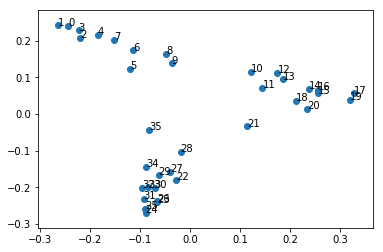

In [35]:
A = read_edge_list('graph-edge-list-2.txt')
embedding = create_embedding(A,2)

%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(embedding[:,1], embedding[:,0])
for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()

It appears that there are three clusters of nodes. We'll use K-Means clustering with a cluster size of 3 to identify the clusters by color.


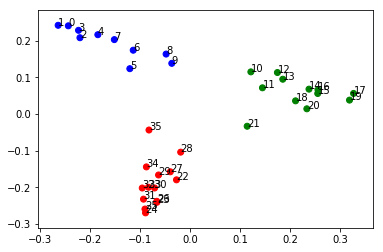

In [41]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(embedding)

plt.scatter(embedding[:,1], embedding[:,0], c=[['R','G','B'][i] for i in kmeans.labels_])

for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()


Another property of the Laplacian Eigenvectors is that the vector corresponding to the second smallest Eigenvalue (this will be vector in column 0 of the embedding) can be used to directly partition the graph into two, approximately equally sized groups, using the smallest number of edge cuts. Using the signs of the Eigenvector elements as a guide, assign nodes whose corresonding elements are positive to one group and rest to the other group.

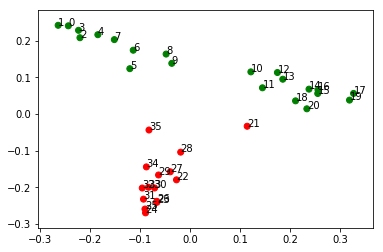

In [46]:
cluster_labels = [int(embedding[:,0][i] > 0.0) for i in range(embedding.shape[0])]

plt.scatter(embedding[:,1], embedding[:,0], c=[['R','G','B'][i] for i in cluster_labels])

for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()

Let's see how this compares to K-Means clustering with a cluster size of 2.

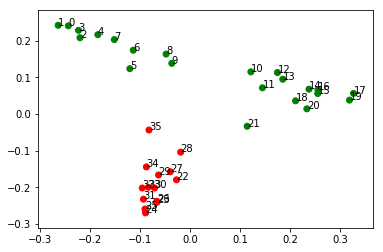

In [42]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(embedding)

plt.scatter(embedding[:,1], embedding[:,0], c=[['R','G','B'][i] for i in kmeans.labels_])

for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()

The results only differ by one node, node 21. Examining the graph, the difference is one edge cut.

What if we use the signs of both vectors in the embeddings

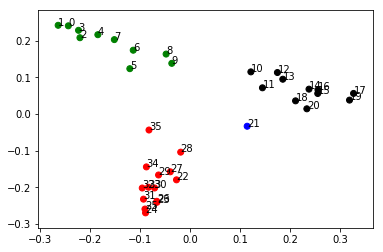

In [50]:
cluster_labels = [int(embedding[:,0][i] > 0.0)*2 + int(embedding[:,1][i] > 0.0) for i in range(embedding.shape[0])]

plt.scatter(embedding[:,1], embedding[:,0], c=[['R','G','B','K'][i] for i in cluster_labels])

for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()

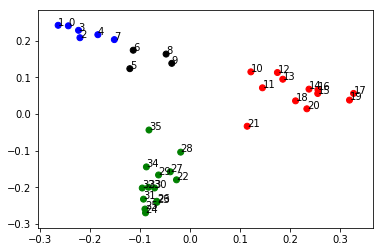

In [49]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(embedding)

plt.scatter(embedding[:,1], embedding[:,0], c=[['R','G','B', 'K'][i] for i in kmeans.labels_])

for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()

<img src="figure-2.png">

In [33]:
def create_embedding(A, k):
    '''
        Computes k-dimension graph node embeddings from
        a graph adjacency matrix.

        Asumes a simple graph, i.e. undirected with no self-loops.
    '''
    assert k <= A.shape[0]
    #
    #   assert that adjacency matrix is symmetric (i.e. undirected graph)
    #
    assert(np.all(A == A.T))
    #
    #   compute diagonal degree matrix but summing along an axis
    #
    D = np.diag(np.sum(A, axis=0))
    #
    #   compute the Laplacian for the graph
    #       - diagonal is node degree
    #       - edge = -1
    #       - no edge = 0
    L = D - A
    #
    #   compute eigen values/vectors
    #       - Note: eigenv ectors are columns in the returns matrix
    #
    values, vectors = np.linalg.eig(L)
    #
    #   sort the eigen values (ascending) and get the sorted indexes
    #
    sorted_value_indexes = sorted(range(len(values)), key=lambda i: values[i])
    #
    #   use the sorted indexes to select the eigenvectors correcsponding the k
    #   smallest eigenvalues, ignoring the first (smallest) value.
    #
    embedding = vectors[:, sorted_value_indexes[1:k+1]]
    #
    #   the embedding for node j is embedding[j], i.e. the jth element from each
    #   eigenvector in the embedding matrix
    #
    return embedding


[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]



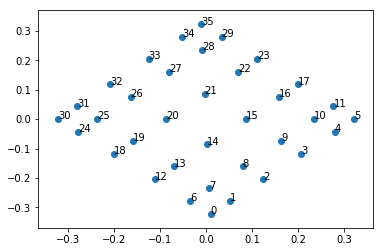

In [21]:
A = make_grid_adjacency_matrix(6)
assert(np.all(A == A.T))  # assert that adjacency matrix is symmetric (i.e. undirected graph)

print(A)
print()
embedding = create_embedding(A,2)

%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(embedding[:,1], embedding[:,0])
for i in range(A.shape[0]):
    plt.annotate(str(i), (embedding[i,1], embedding[i,0]))
plt.show()
